In [3]:
#!jupyter nbconvert --to=python NPP_TotalGlobal_python3.ipynb

[NbConvertApp] Converting notebook NPP_TotalGlobal.ipynb to python
[NbConvertApp] Writing 4373 bytes to NPP_TotalGlobal.py


In [81]:
class NPP_TotalGlobal:
    '''
    class NPP_TotalGlobal(runname,resultpath,savepath,meshpath,first_year,last_year,
                 mapproj='pc',savefig=False,layerwise=False)
    '''
    def __init__(self,runname,resultpath,savepath,meshpath,first_year,last_year,
                 mapproj='pc',
                 savefig=False,
                 layerwise=False,depth_array=[]):

        self.runname = runname
        self.resultpath = resultpath
        self.savepath = savepath
        self.meshpath = meshpath
        self.fyear = first_year
        self.lyear = last_year
        self.mapproj = mapproj
        self.savefig = savefig
        self.layerwise = layerwise
        self.depth_array = depth_array

        import matplotlib.pyplot as plt
        import numpy as np
        from netCDF4 import Dataset
        from scipy.interpolate import griddata
        import skill_metrics as sm
        import cartopy.crs as ccrs
        #import pickle

        import pyfesom2 as pf


        # load FESOM mesh -------------------------------------------------------------------------------------
        mesh       = pf.load_mesh(meshpath)
        years = range(self.fyear, self.lyear+1)
        
        
        # load nodal area -------------------------------------------------------------------------------------
        f = Dataset(self.resultpath + '/' + self.runname + '.mesh.diag.nc', 'r')
        nod_area = f.variables['nod_area'][:]
        nod_area_surface = nod_area[0,:]
        
        #print('shape nod_area: {0}\nshape nod_area_surface: {1}'.format(np.shape(nod_area),np.shape(nod_area_surface)))
        
        ## same as original code?? -->
        #f           = Dataset(self.ncfileNPPTotalGlobal, 'r')
        #NodalArea2D = f.variables['cluster_area'][:]
        #f           = Dataset(self.meshpath+'/griddes.nc', 'r')
        #cell_area = f.variables['cell_area'][:]
        
        # ?????????? what was done here in FESOM1.4 ??????????????
        #depths = np.unique(mesh.z3)
        #ep_ind = np.nonzero((depths == 100))
        #ep_ind = np.squeeze(mesh.n32[:,ep_ind])
        #ep_surf= np.squeeze(np.nonzero((ep_ind>-999)))
        #ep_ind = np.delete(ep_ind,np.nonzero((ep_ind==-999))) # Only real indexes are kept
        
        
        # calculating total NPP per year -------------------------------------------------------------------------------
        NPPtotal = np.zeros(len(years))
        DiaTotal  = np.zeros(len(years))
        NanoTotal = np.zeros(len(years))
        EPtotal   = np.zeros(len(years))
        
        for i in range(len(years)):
            ind_year = years[i]
            print('loading {0}'.format(ind_year))
            
            NPPn = pf.get_data(resultpath, "NPPn", ind_year, mesh, how="mean", compute=True, runid=self.runname, silent=True)
            NPPd = pf.get_data(resultpath, "NPPd", ind_year, mesh, how="mean", compute=True, runid=self.runname, silent=True)
            ## NPPn:units = "mmolC/(m2*d)"
                
            NPPtotal_aux       = (NPPd+NPPn)*12.01
            NPPtotal_aux       = 365 * NPPtotal_aux    # Conversion from [mg/m2/day]   => [mg/m2/yr]
            #print('shape NPPtotal: {0}'.format(np.shape(NPPtotal_aux)))
            
            NPPtotal[i] = np.sum(NPPtotal_aux*nod_area_surface)/1e18  # summing up and converting to [Pg C/year]
        
            NanoTotal[i] = np.sum(12.01*365.*NPPn*nod_area_surface)/1e18 
            DiaTotal[i]  = np.sum(12.01*365.*NPPd*nod_area_surface)/1e18
            
            DetC = pf.get_data(resultpath, "DetC", ind_year, mesh, how="mean", compute=True, runid=self.runname, silent=True)
            Vdet = 0.0288 * 100. + 20. ## what's this?
            DetC = 365. * DetC * 12.01 * Vdet # [mmol/m3] => [mg/m2/yr]
            #EPtotal[i] = np.sum(DetC[ep_ind]*NodalArea2D[ep_surf])/1e18
        
        # plotting total NPP -------------------------------------------------------------------------------        
        fig = plt.figure(figsize=(12,8), facecolor='w', edgecolor='k', tight_layout = True)
        plt.subplot(2, 3, 1)
        plt.plot(years,NPPtotal,'.-',label='Total')
        #plt.plot(years,NanoTotal,'.-g',label='Nano')
        #plt.plot(years,DiaTotal,'.-r',label='Dia')
        plt.title(self.runname+': Global NPP')
        plt.ylabel(r'[Pg C yr$^{-1}$]')
        plt.legend(loc='center right')
        
        plt.subplot(2, 3, 2)
        #plt.plot(years,NPPtotal,'.-',label='Total')
        plt.plot(years,NanoTotal,'.-g',label='Nano')
        #plt.plot(years,DiaTotal,'.-r',label='Dia')
        #plt.title(self.runname+': Global NPP')
        #plt.ylabel(r'[Pg C yr$^{-1}$]')
        plt.legend(loc='center right')
        
        plt.subplot(2, 3, 3)
        #plt.plot(years,NPPtotal,'.-',label='Total')
        #plt.plot(years,NanoTotal,'.-g',label='Nano')
        plt.plot(years,DiaTotal,'.-r',label='Dia')
        #plt.title(self.runname+': Global NPP')
        #plt.ylabel(r'[Pg C yr$^{-1}$]')
        plt.legend(loc='center right')

        #fig = plt.figure(figsize=(4,4), facecolor='w', edgecolor='k')
        plt.subplot(2, 3, 4)
        #plt.plot(years,EPtotal,'.')
        plt.title(self.runname+': Global EP')
        plt.ylabel(r'[Pg C yr$^{-1}$]')

        if(savefig):
            plt.savefig(self.savepath+self.runname+'_'+'NPP_TotalGlobal_'+str(self.fyear)+'to'+str(self.lyear)+'.png', dpi = 300, bbox_inches='tight')
        plt.show(block=False)

shape nod_area: (48, 126858)
shape nod_area_surface: (126858,)
loading 1948
shape NPPtotal: (126858,)
loading 1949
shape NPPtotal: (126858,)
loading 1950
shape NPPtotal: (126858,)


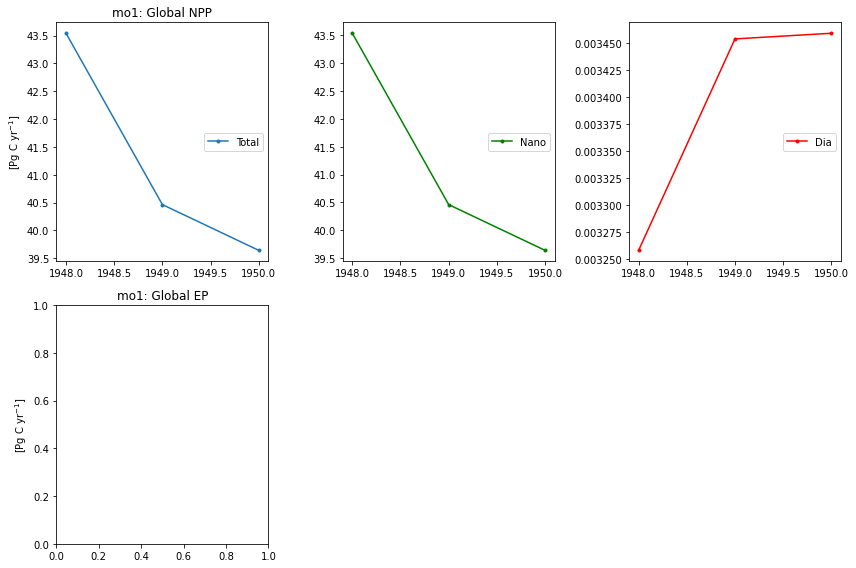

In [82]:
### TESTING ###
if __name__ == "__main__":
    import pyfesom2 as pf
    import numpy as np
    
    # run specification -------------------------------------------------------------------------------------
    runid      =  'mo1'
    resultpath = '/work/ollie/mozeisin/results/f2r1.2/' + runid
    savepath = '/home/ollie/mozeisin/evaluation/mo_files/'

    htmlname     =  runid + '.html'
    htmlpath = '/home/ollie/mozeisin/evaluation/mo_files/html/'

    meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

    #modulepath = '/home/ollie/mozeisin/py_recom/GlobalAssessment'
    #modulepath   = '/home/ollie/jhauck/py_fesom/modules/'

    #obspath      = '/home/ollie/mseifert/py_fesom/CreateRunFiles/Initialization/Output/'

    # period of analysis ------------------------------------------------------------------------------------

    first_year = 1948
    last_year  = 1950

    # WOA ------------------------------------------------------------------------------------    
#    ncpath = ncfileDIC
    #!ncdump -h $ncpath
    
    # now test:runname,resultpath,savepath,meshpath,first_year,last_year
    test = NPP_TotalGlobal(runid,resultpath,savepath,meshpath,first_year,last_year,layerwise=False,savefig=False)

In [76]:
## overview nc files
if(__name__ == '__main__'):
    !ncdump -h '/work/ollie/mozeisin/results/f2r1.2/mo1/mo1.mesh.diag.nc'
    !ncdump -h '/work/ollie/mozeisin/results/f2r1.2/mo1/NPPn.mo1.1948.nc'

netcdf mo1.mesh.diag {
dimensions:
	nod_n = 126858 ;
	edg_n = 371644 ;
	elem_n = 244659 ;
	nl = 48 ;
	nl1 = 47 ;
	n2 = 2 ;
	n3 = 3 ;
	n4 = 4 ;
	N = 9 ;
variables:
	double zbar(nl) ;
		zbar:long_name = "depth of levels" ;
	double Z(nl1) ;
		Z:long_name = "depth of layers" ;
	double elem_area(elem_n) ;
		elem_area:long_name = "element areas" ;
	int nlevels_nod2D(nod_n) ;
		nlevels_nod2D:long_name = "number of levels below nodes" ;
	int nlevels(elem_n) ;
		nlevels:long_name = "number of levels below elements" ;
	int nod_in_elem2D_num(nod_n) ;
		nod_in_elem2D_num:long_name = "number of elements containing the node" ;
	int nod_part(nod_n) ;
		nod_part:long_name = "nodal partitioning at the cold start" ;
	int elem_part(elem_n) ;
		elem_part:long_name = "element partitioning at the cold start" ;
	double zbar_e_bottom(elem_n) ;
		zbar_e_bottom:long_name = "element bottom depth" ;
	double zbar_n_bottom(nod_n) ;
		zbar_n_bottom:long_name = "nodal bottom depth" ;
	double nod_area(nl, nod_n) ;
		n

### old version:

    def __init__(self,runname,resultpath,savepath,modulepath,meshpath,first_year,last_year,ncfileNPPTotalGlobal,
                 layerwise):
        self.runname=runname
        self.resultpath=resultpath
        self.savepath=savepath
        self.modulepath=modulepath
        self.meshpath=meshpath
        self.first_year=first_year
        self.last_year=last_year
        self.ncfileNPPTotalGlobal=ncfileNPPTotalGlobal
        self.layerwise = layerwise
        
    def plot(self):
        import sys
        sys.path.append(self.modulepath)

        import matplotlib.pyplot as plt
        from load_mesh_data_new import load_mesh
        import numpy as np
        import pylab as p
        from netCDF4 import Dataset
        
        runid       = 'fesom'

        years       = np.arange(self.first_year,self.last_year+1,1)
        months      = np.linspace(0,11,12).astype(int)

        mesh        = load_mesh(self.meshpath,abg=[0,0,0],get3d=True)
        
        f           = Dataset(self.ncfileNPPTotalGlobal, 'r')
        NodalArea2D = f.variables['cluster_area'][:]
        
        f           = Dataset(self.meshpath+'/griddes.nc', 'r')
        cell_area = f.variables['cell_area'][:]        
        
        var_id1, var_id2, var_id3, depth ='NPPn','NPPd', 'bgc08', 0

        depths = np.unique(mesh.z3)
        ep_ind = np.nonzero((depths == 100))
        ep_ind = np.squeeze(mesh.n32[:,ep_ind])
        ep_surf= np.squeeze(np.nonzero((ep_ind>-999)))
        ep_ind = np.delete(ep_ind,np.nonzero((ep_ind==-999))) # Only real indexes are kept 

        Vdet=0.0288 * 100. + 20.
        
        NPPtotal1 = np.zeros(len(years))
        DiaTotal  = np.zeros(len(years))
        NanoTotal = np.zeros(len(years))
        EPtotal   = np.zeros(len(years))
        for ind in range(0,len(years)):
            print years[ind]
            ncfile1        = self.resultpath+var_id1+'_'+runid+'_'+str(years[ind])+'0101'+'.nc'
            ncfile2        = self.resultpath+var_id2+'_'+runid+'_'+str(years[ind])+'0101'+'.nc'
            f1             = Dataset(ncfile1, 'r')
            f2             = Dataset(ncfile2, 'r')
            npp1           = f1.variables[var_id1][:].mean(axis=0)
            npp2           = f2.variables[var_id2][:].mean(axis=0)
            NPPtotal       = (npp1+npp2)*12.01
            NPPtotal       = 365 * NPPtotal    # Conversion from [mg/m2/day]   => [mg/m2/yr]
            NPPtotal1[ind] = np.sum(NPPtotal*NodalArea2D)/1e18  # summing up and converting to [Pg C/year]
            NanoTotal[ind] = np.sum(12.01*365.*npp1*NodalArea2D)/1e18 
            DiaTotal[ind]  = np.sum(12.01*365.*npp2*NodalArea2D)/1e18 

            ncfile3      = self.resultpath+var_id3+'_'+runid+'_'+str(years[ind])+'0101'+'.nc'
            f3           = Dataset(ncfile3, 'r')  
            detc         = f3.variables[var_id3][:].mean(axis=0)
            detc         = 365. * detc * 12.01 * Vdet # [mmol/m3] => [mg/m2/yr]
            if self.layerwise:
#                print 'layerwise'
                print 'np.shape(detc[10,:]): ', np.shape(detc[10,:])
                #print 'np.shape(NodalArea2D[ep_surf])): ', np.shape(NodalArea2D[ep_surf])
                EPtotal[ind] = np.sum(detc[10,:]*cell_area)/1e18    
            else:
 #               print 'not layerwise'
                print 'np.shape(detc[ep_ind]): ', np.shape(detc[ep_ind])
                EPtotal[ind] = np.sum(detc[ep_ind]*NodalArea2D[ep_surf])/1e18 
        
        fig = plt.figure(num=24, figsize=(8, 8), facecolor='w', edgecolor='k')
        plt.subplot(2, 1, 1)
        plt.plot(years,NPPtotal1,'.-',label='Total')
        plt.plot(years,NanoTotal,'.-g',label='Nano')
        plt.plot(years,DiaTotal,'.-r',label='Dia')
        plt.title(self.runname+': Global NPP')
        plt.ylabel(r'[Pg C yr$^{-1}$]')
        plt.legend()#(loc='lower left')

        plt.subplot(2, 1, 2)
        plt.plot(years,EPtotal,'.')
        plt.title(self.runname+': Global EP')
        plt.ylabel(r'[Pg C yr$^{-1}$]')

        plt.savefig(self.savepath+self.runname+'_'+'NPP_TotalGlobal'+'_'+str(years[0])+'to'+str(years[len(years)-1])+'.png', dpi = 200, bbox_inches='tight')
        plt.show(block=False)
        
        